<a href="https://colab.research.google.com/github/forbiddenvelocity/Kolmogorov-Arnold-Network/blob/loss-functions/Kolmogorov_Arnold_Newtwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [43]:
class OneDimSubnet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(OneDimSubnet, self).__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout(self.activation(self.fc2(x)))
        x = self.dropout(self.activation(self.fc3(x)))
        x = self.fc4(x)
        return x

In [27]:
class KolmogorovArnoldNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_subnets):
        super(KolmogorovArnoldNN, self).__init__()
        self.subnets = nn.ModuleList([OneDimSubnet(1, hidden_dim) for _ in range(num_subnets)])
        self.final_layer = nn.Linear(num_subnets, output_dim)

    def forward(self, x):
        outputs = []
        for i in range(x.size(1)):
            subnet_output = self.subnets[i](x[:, i].unsqueeze(1))
            outputs.append(subnet_output)
        concatenated_outputs = torch.cat(outputs, dim=1)
        final_output = self.final_layer(concatenated_outputs)
        return final_output

In [34]:
class StandardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StandardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
def train_model(model, criterion, optimizer, x, y, num_epochs):
    loss_history = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss_history


In [57]:
input_dim = 3
hidden_dim = 5
output_dim = 1
num_epochs = 1000
learning_rate = 0.005
batch_size = 32
num_subnets = input_dim  # Number of subnets should match the input dimension

# Create dummy data
x = torch.randn((100, input_dim))
y = torch.randn((100, output_dim))

# Initialize models, loss function and optimizers
kann_mse = KolmogorovArnoldNN(input_dim, hidden_dim, output_dim, num_subnets)
kann_mae = KolmogorovArnoldNN(input_dim, hidden_dim, output_dim, num_subnets)
kann_huber = KolmogorovArnoldNN(input_dim, hidden_dim, output_dim, num_subnets)
optimizer_mse = optim.Adam(kann_mse.parameters(), lr=learning_rate)
optimizer_mae = optim.Adam(kann_mae.parameters(), lr=learning_rate)
optimizer_huber = optim.Adam(kann_huber.parameters(), lr=learning_rate)

In [58]:
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
criterion_huber = nn.SmoothL1Loss()

loss_mse = train_model(kann_mse, criterion_mse, optimizer_mse, x, y, num_epochs)
loss_mae = train_model(kann_mae, criterion_mae, optimizer_mae, x, y, num_epochs)
loss_huber = train_model(kann_huber, criterion_huber, optimizer_huber, x, y, num_epochs)


Epoch [100/1000], Loss: 1.0897
Epoch [200/1000], Loss: 1.0370
Epoch [300/1000], Loss: 0.9604
Epoch [400/1000], Loss: 0.9050
Epoch [500/1000], Loss: 0.8905
Epoch [600/1000], Loss: 0.8627
Epoch [700/1000], Loss: 0.8509
Epoch [800/1000], Loss: 0.8312
Epoch [900/1000], Loss: 0.8420
Epoch [1000/1000], Loss: 0.8127
Epoch [100/1000], Loss: 0.7996
Epoch [200/1000], Loss: 0.7563
Epoch [300/1000], Loss: 0.7556
Epoch [400/1000], Loss: 0.7384
Epoch [500/1000], Loss: 0.7413
Epoch [600/1000], Loss: 0.7307
Epoch [700/1000], Loss: 0.7346
Epoch [800/1000], Loss: 0.7421
Epoch [900/1000], Loss: 0.7322
Epoch [1000/1000], Loss: 0.7143
Epoch [100/1000], Loss: 0.4278
Epoch [200/1000], Loss: 0.4051
Epoch [300/1000], Loss: 0.3977
Epoch [400/1000], Loss: 0.3804
Epoch [500/1000], Loss: 0.3746
Epoch [600/1000], Loss: 0.3927
Epoch [700/1000], Loss: 0.3653
Epoch [800/1000], Loss: 0.3645
Epoch [900/1000], Loss: 0.3570
Epoch [1000/1000], Loss: 0.3906


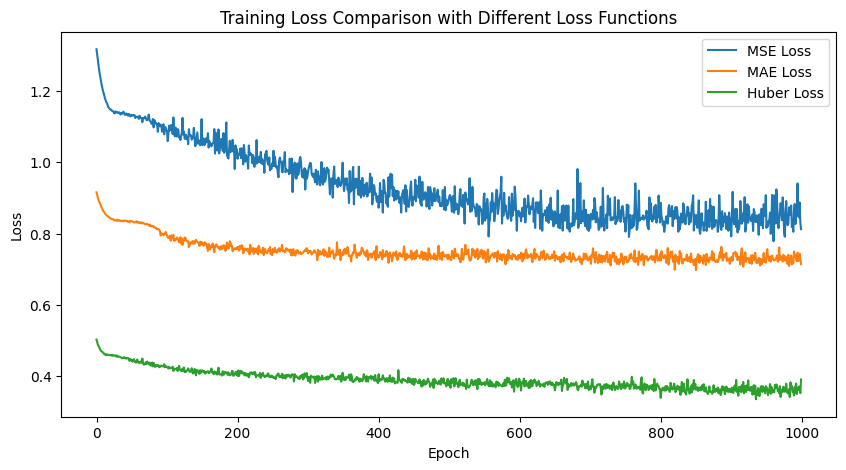

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(loss_mse, label='MSE Loss')
plt.plot(loss_mae, label='MAE Loss')
plt.plot(loss_huber, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison with Different Loss Functions')
plt.legend()
plt.show()